## Alerts for flares

uses environment 'envs/env_alert.yml'

run data_update_web_hf.pynb to produce a new xray file

for testing, delete the alert_list_flare.p files


Issues: 


In [1]:
#debug mode turns telegram notifications off and introduces an artifical flare data point
#debug_mode=True

#use for deployment
debug_mode=False

if debug_mode:
    print('no telegram alerts will be sent')
else:
    print('telegram alerts will be sent')

import os
os.system('jupyter nbconvert --to script alert_flare.ipynb')  


telegram alerts will be sent


[NbConvertApp] Converting notebook alert_flare.ipynb to script
[NbConvertApp] Writing 10557 bytes to alert_flare.py


0

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import urllib
import pandas as pd
import sys
import importlib
import email
import smtplib
import requests

from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from alerts import alert_server_ids as aid

#Dst threshold definition for defining an alert
threshold1=1e-4   #for X1 Watts per m^2
threshold2=5*1e-4 #for X5
threshold3=1e-3   #for X10

print('thresholds set to ',threshold1, '  ', threshold2,'  ', threshold3,'  ')

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    from config_server import data_path
    matplotlib.use('Agg') 
        
#mac
if sys.platform =='darwin':  
    print('system is mac')
    from config_local import data_path    
    #matplotlib.use('Agg') 
    %matplotlib inline     

print(data_path)

thresholds set to  0.0001    0.0005    0.001   
system is mac
/Users/chris/python/data/insitu_python/


### get xray data and plot

In [3]:
filenoaa='noaa_xray_last_7days_now.p'
[d1,d2]=pickle.load(open(data_path+filenoaa, "rb"))


####################### for testing set 8 minutes before present to X4 flare
if debug_mode: 
    d1.flux[-8]=4*1e-4 #X4 flare


/var/folders/tr/3wb8vxgd5sj97xz5dz09q0qm0000gn/T/ipykernel_2820/3948268243.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


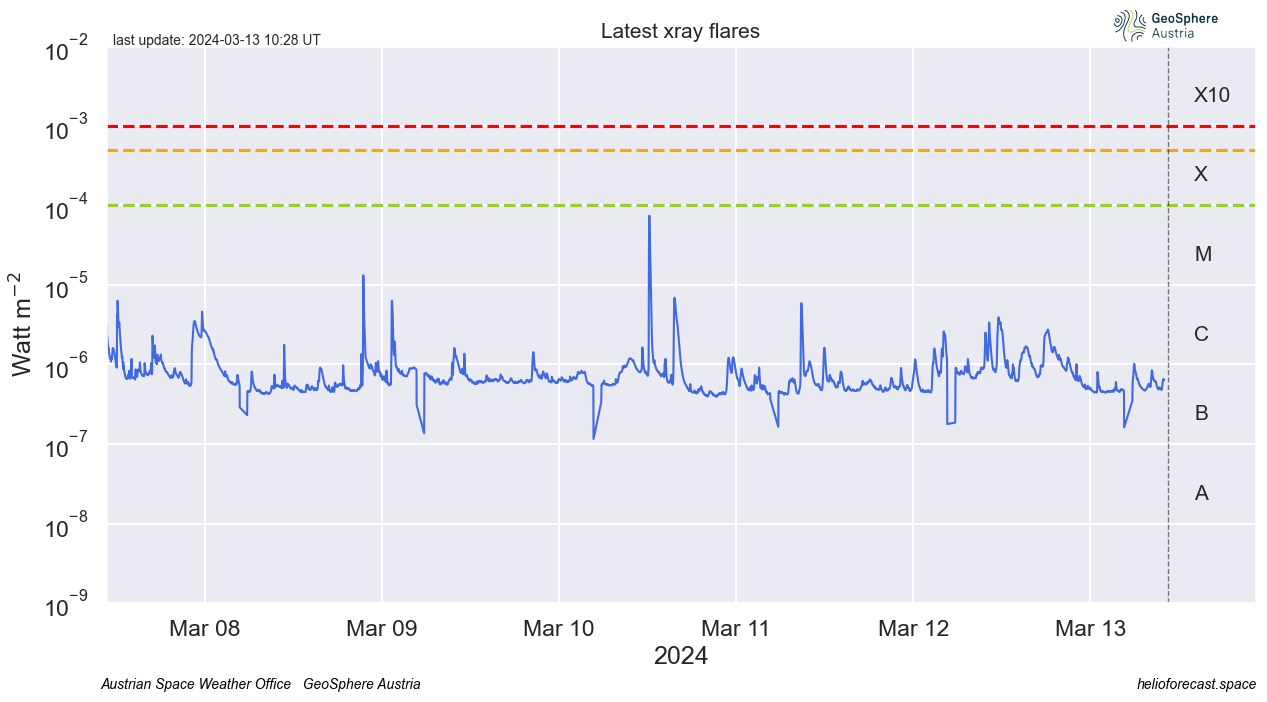

In [4]:
sns.set_context('talk')
sns.set_style('darkgrid')
fig, ax1=plt.subplots(1,figsize=(13,7),dpi=100)

ax1.axhline(y=threshold1, color='yellowgreen', linestyle='--',label='X1')
ax1.axhline(y=threshold2, color='orange', linestyle='--',label='X5')
ax1.axhline(y=threshold3, color='red', linestyle='--',label='X10')

ax1.axvline(x=datetime.datetime.utcnow(), color='k', linestyle='--',alpha=0.5, linewidth=1.0)
ax1.plot(d1.time,d1.flux,color='royalblue',linewidth=1.5,alpha=1.0)

ax1.set_yscale('log')
ax1.set_ylabel('Watt m$^{-2}$')

plt.title('Latest xray flares',fontsize=15)
ax1.set_xlim(datetime.datetime.utcnow()-datetime.timedelta(days=6),datetime.datetime.utcnow()+datetime.timedelta(days=0.5))
ax1.xaxis.set_major_locator(mdates.DayLocator())
myformat = mdates.DateFormatter('%b %d')
ax1.xaxis.set_major_formatter(myformat)
ax1.set_xlabel(datetime.datetime.utcnow().year)


logo = plt.imread('logo/GSA_Basislogo_Positiv_RGB_XXS.png')
newax = fig.add_axes([0.87,0.90,0.08,0.08], anchor='NE', zorder=1)
newax.imshow(logo)
newax.axis('off')

ax1.set_ylim(1e-9,1e-2)

fsize=12

plt.figtext(0.09,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-2, style='italic')
plt.figtext(0.98,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-2, style='italic')
plt.figtext(0.10,0.93,'last update: '+str(datetime.datetime.utcnow())[0:16]+ ' UT', ha='left', fontsize=10)

plt.tight_layout()

ax1.annotate('X10',xy=(datetime.datetime.utcnow()+datetime.timedelta(days=0.15),2*1e-3),xycoords='data',fontsize=15,ha='left')
ax1.annotate('X',xy=(datetime.datetime.utcnow()+datetime.timedelta(days=0.15),2*1e-4),xycoords='data',fontsize=15,ha='left')
ax1.annotate('M',xy=(datetime.datetime.utcnow()+datetime.timedelta(days=0.15),2*1e-5),xycoords='data',fontsize=15,ha='left')
ax1.annotate('C',xy=(datetime.datetime.utcnow()+datetime.timedelta(days=0.15),2*1e-6),xycoords='data',fontsize=15,ha='left')
ax1.annotate('B',xy=(datetime.datetime.utcnow()+datetime.timedelta(days=0.15),2*1e-7),xycoords='data',fontsize=15,ha='left')
ax1.annotate('A',xy=(datetime.datetime.utcnow()+datetime.timedelta(days=0.15),2*1e-8),xycoords='data',fontsize=15,ha='left')

plt.savefig('alerts/alert_flare.png',dpi=100)

### alert functions

In [5]:
#with outlook as sender, gmail does not work
#use outlook.com aswo-space@outlook.com account for testing

def send_alert_email(time,dstval):

    ######### get email list from file if needed
    #email_file_path='alerts/alert_email_list.txt'
    #with open(email_file_path, "r") as file:
    #    email_list = []
    #    for line in file:
    #        # Remove leading and trailing whitespace (e.g., newline characters)
    #        string = line.strip()
    #        email_list.append(string)
    #print(email_list)      
    recipients=email_list
    
    msg = MIMEMultipart()
    msg['From'] = aid.smtp_username
    
    msg['Subject'] = 'Geomagnetic storm alert, Austrian Space Weather Office, GeoSphere Austria'

    
    time_formatted=time.strftime("%Y %b %d %H:00 UT")
    
    email_body =""" Dear Space Weather enthusiast, 
    
    there is currently an ongoing geomagnetic storm with 
    
    Dst {} nT at  {},

    Happy aurora hunting! 
    
    The ASWO team
    https://helioforecast.space
    """.format(dstval, time_formatted)
        
    msg.attach(MIMEText(email_body, 'plain'))

    server = smtplib.SMTP(aid.smtp_server, aid.smtp_port)
    server.starttls()  # Use TLS encryption
    server.login(aes.smtp_username, aid.smtp_password)
    
    #add list for all into one string
    msg['Bcc'] = ', '.join(recipients)
    try:
        server.sendmail(aes.smtp_username, recipients, msg.as_string())
        print("Email sent to ", recipients)
    except Exception as e:
        print("Error sending email:", str(e), recipients)
        
    server.quit()
       
  

In [6]:
def send_telegram_message(time,fluxval):
    
    # Replace 'YOUR_BOT_TOKEN' with the actual token you received from BotFather
    bot_token = aid.bot_token

    # Replace 'YOUR_CHAT_ID' with the chat ID of the user or group where you want to send the message
    chat_id = aid.chat_id

    time_formatted=time.strftime("%Y %b %d %Hh UTC")
    
    # The message you want to send
    message_text = """ Hi, there is a strong flare happening: 
GOES flux X{} at {} 
The ASWO team
https://helioforecast.space/dashboard""".format(fluxval, time_formatted)

    # Create the URL for the Telegram Bot API endpoint
    api_url = f'https://api.telegram.org/bot{bot_token}/sendMessage'

    # Prepare the parameters for the message
    params = {
        'chat_id': chat_id,
        'text': message_text
    }

    # Send the message using a POST request
    response = requests.post(api_url, data=params)

    # Check the response from the Telegram API
    if response.status_code == 200:
        print('Message sent successfully to ASWO alerts')
    else:
        print('Failed to send the message.')
        print(response.text)

### Check latest data

In [7]:
time_now=datetime.datetime.utcnow()

print(' ')
print('------------------------------------------------------------------')
print('start flare alert check at',time_now.strftime("%Y-%b-%d %H:%M:%S UT"))
print()
time_now_num=mdates.date2num(time_now)

print('latest flare data (GOES): ')
for i in np.arange(-26,0):
    formatted_date = d1.time[i].strftime("%Y-%b-%d %H:%M UTC")
    flux_x1_level=np.round(d1.flux[i]*1e4,4)
    print(formatted_date,'   X',flux_x1_level)
#print('done')

print(' ')
#check the latest 25 minutes and take the maximum (because the frequency of the alert to be called is 10-20 minutes)
d1_max_25=np.round(np.nanmax(d1.flux[-26:]),6)
d1_max_25_xl=np.round(np.nanmax(d1.flux[-26:])*1e4,6)

#check the time of that maximum data point in the last 25 minutes
d1_max_25_time=d1.time[-26:][np.nanargmax(d1.flux[-26:])]

print('Maximum flux of the last 25 minutes    X',d1_max_25_xl,' at', d1_max_25_time)

 
------------------------------------------------------------------
start flare alert check at 2024-Mar-13 10:28:46 UT

latest flare data (GOES): 
2024-Mar-13 09:36 UTC    X 0.0048
2024-Mar-13 09:37 UTC    X 0.0048
2024-Mar-13 09:38 UTC    X 0.0049
2024-Mar-13 09:39 UTC    X 0.0048
2024-Mar-13 09:40 UTC    X 0.0048
2024-Mar-13 09:41 UTC    X 0.0048
2024-Mar-13 09:42 UTC    X 0.0048
2024-Mar-13 09:43 UTC    X 0.0049
2024-Mar-13 09:44 UTC    X 0.0051
2024-Mar-13 09:45 UTC    X 0.0053
2024-Mar-13 09:46 UTC    X 0.0055
2024-Mar-13 09:47 UTC    X 0.0057
2024-Mar-13 09:48 UTC    X 0.0058
2024-Mar-13 09:49 UTC    X 0.0059
2024-Mar-13 09:50 UTC    X 0.006
2024-Mar-13 09:51 UTC    X 0.0062
2024-Mar-13 09:52 UTC    X 0.0063
2024-Mar-13 09:53 UTC    X 0.0065
2024-Mar-13 09:54 UTC    X 0.0066
2024-Mar-13 09:55 UTC    X 0.0065
2024-Mar-13 09:56 UTC    X 0.0065
2024-Mar-13 09:57 UTC    X 0.0065
2024-Mar-13 09:58 UTC    X 0.0065
2024-Mar-13 09:59 UTC    X 0.0064
2024-Mar-13 10:00 UTC    X 0.0064
202

## Alert for threshold 1


In [8]:
if d1_max_25 < threshold1: 
    print('Flux below threshold',threshold1,'flux, no alert triggered')

if d1_max_25>= threshold1: 
    
    print('------------ Alert triggered')
    print('Maximum flux is X',d1_max_25_xl, ' above the threshold of >= X',threshold1*1e4)
    print(' ')
    print('Was alert already sent in last 3 hours?')
    print(' ')

    #read list of sent out alert times from a pickle file
    file_path = 'alerts/alert_list_flare.p'
    
    if os.path.exists(file_path):
        print('Alerts file exists')
        atime_list=pickle.load(open(file_path, "rb" ) )   
        atime_list_num=mdates.date2num(atime_list)
    else:
        print('Alerts file does not exist, file created')
        #create a dummy list if the file is not there, and create the pickle file
        atime_list=[datetime.datetime(2023, 9, 15, 18, 0), \
                     datetime.datetime(2023, 9, 25, 7, 0)]        
        atime_list_num=mdates.date2num(atime_list)
        pickle.dump(atime_list, open('alerts/alert_list_flare.p', 'wb') )
    
    
    print('latest alerts from pickle file')
    for i in np.arange(0,len(atime_list)):
        print(atime_list[i].strftime("%Y-%m-%dT%H:%MZ") )
    
    
    print('')
        
    #go through all times and check whether one was in the last 3 hours or 1/8 days in matplotlib times
    if np.nanmin(time_now_num-atime_list_num) > 0.125:   
        
        print('no, alert will be sent')       
                     
        print('Alert time and flux written to file alerts/alert_list_flare.txt and alert_list_flare.p')
        
        alert_time_for_file=d1.time[-1].strftime("%Y-%m-%dT%H:%MZ")
        print(alert_time_for_file+' '+str(d1_max_25) )    
                
        #write this to a text file
        with open('alerts/alert_list_flare.txt', 'a') as file:
            file.write(alert_time_for_file)
            file.write(' '+str(d1_max_25)+'\n')
            
        #append to list and write to pickle file    
        atime_list.append(d1.time[-1])
        pickle.dump(atime_list, open('alerts/alert_list_flare.p', 'wb') )            
        
        
        #if debug_mode is off, send message
        if debug_mode==False:
            send_telegram_message(d1_max_25_time,d1_max_25*1e4)
        
                        
        #write into file the time of the sent alert
    else: 
        print('yes, no alert sent')
        
    

Flux below threshold 0.0001 flux, no alert triggered


### Alert for threshold 2, same setup as for threshold 1, not used so far

In [9]:
 
 
print(' ')
print(' ')
print('end flare alert program')

print('------------------------------------------------------------------')

 
 
end flare alert program
------------------------------------------------------------------
